# PROBLEM SET 7: CLUSTERING AND ANOMALY DETECTION

### SEAN XANDER B. AQUINO BSCS 2A

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo

C:\Users\Sean Xander Aquino\AppData\Local\Temp\ipykernel_18808\3758845371.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Loading the dataset


In [2]:
def load_wine_data(wine_type='white'):
    wine_quality = fetch_ucirepo(id=186) 
    df = wine_quality.data.features
    df['quality'] = wine_quality.data.targets
    return df

### Visualize the distributions of all features in the dataset with Gaussian fit.


In [3]:
def visualize_feature_distributions_with_fit(df):
    feature_names = df.columns[:-1]  # Exclude the 'quality' column
    num_features = len(feature_names)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_features + num_cols - 1) // num_cols 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, feature in enumerate(feature_names):
        data = df[feature].dropna()  # Drop NaN values if any
        mu, std = norm.fit(data) 
        sns.histplot(data, bins=25, kde=False, stat='density', color='skyblue', ax=axes[i])
        
        # Plot the PDF
        xmin, xmax = axes[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        axes[i].plot(x, p, 'k', linewidth=2)
        
        axes[i].set_title(f'{feature}\nFit: μ={mu:.2f}, σ={std:.2f}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')
        axes[i].grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### Test the normality of a feature by fitting a Gaussian distribution.


In [4]:
def test_normality(data, feature_name):
    mu, std = norm.fit(data)
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=50, kde=False, stat='density', color='skyblue', edgecolor='black')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title(f'Gaussian Fit on {feature_name}: μ={mu:.2f}, σ={std:.2f}')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    return mu, std

### Compute the PDF values for a feature based on a Gaussian distribution.


In [5]:
def compute_pdf(data, mu, std):
    pdf_values = norm.pdf(data, mu, std)
    return pdf_values

### Apply KMeans clustering to the PDF values.


In [6]:
def apply_kmeans(pdf_values, n_clusters=2):
    reshaped = pdf_values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reshaped)
    labels = kmeans.labels_
    return labels, kmeans

### Identify anomalies based on the cluster with the lowest mean PDF value.


In [7]:
def identify_anomalies(pdf_values, labels, kmeans):
    cluster_means = [pdf_values[labels == i].mean() for i in range(kmeans.n_clusters)]
    anomaly_cluster = np.argmin(cluster_means)
    anomalies = labels == anomaly_cluster
    return anomalies

### Compute silhouette scores for different numbers of clusters and plot the results.


In [8]:
def compute_and_plot_silhouette_scores(pdf_values):
    sil = []
    kmax = 150

    # Compute silhouette scores for k = 2 to kmax
    for k in range(2, kmax + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(pdf_values.reshape(-1, 1))
        labels = kmeans.labels_
        sil.append(silhouette_score(pdf_values.reshape(-1, 1), labels, metric='euclidean'))

    # Calculate the mean silhouette score
    mean_score = float('%.2f' % (sum(sil) / len(sil)))

    # Plot the silhouette scores and the mean
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, kmax + 1), sil, label='Silhouette Score', color='blue')
    plt.axhline(y=mean_score, color='red', linestyle='--', label=f'Mean Score: {mean_score}')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.grid(True)
    plt.show()

### Visualizing the results of anomaly detection.


In [9]:
def visualize_results(data, pdf_values, anomalies, feature_name):
    # Histogram of PDF values
    plt.figure(figsize=(10, 6))
    sns.histplot(pdf_values, bins=50, color='skyblue', edgecolor='black')
    plt.title('Histogram of PDF Values')
    plt.xlabel('PDF Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Boxplot of PDF values
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=pdf_values)
    plt.title('Boxplot of PDF Values')
    plt.xlabel('PDF Value')
    plt.grid(True)
    plt.show()

    # Scatter plot of anomalies
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(data)), data, c=~anomalies, cmap='coolwarm', edgecolor='k')
    plt.title(f'Anomaly Detection based on {feature_name}')
    plt.xlabel('Index')
    plt.ylabel(feature_name)
    plt.grid(True)
    plt.show()

### Running a simulation of the anomaly detection.


In [10]:
def run_anomaly_detection(feature_name='residual sugar', wine_type='white'):
    print("Loading data...")
    df = load_wine_data(wine_type)

    # Standard scale the data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns='quality')), columns=df.columns[:-1])

    print("Visualizing feature distributions with Gaussian fit...")
    visualize_feature_distributions_with_fit(df_scaled)

    data = df_scaled[feature_name].astype(float).values

    print(f"Testing normality for {feature_name}...")
    mu, std = test_normality(data, feature_name)

    print("Computing PDF values...")
    pdf_values = compute_pdf(data, mu, std)

    print("Applying KMeans clustering...")
    labels, kmeans = apply_kmeans(pdf_values)

    print("Identifying anomalies...")
    anomalies = identify_anomalies(pdf_values, labels, kmeans)

    print("Computing and plotting silhouette scores...")
    compute_and_plot_silhouette_scores(pdf_values)

    print("Visualizing results...")
    visualize_results(data, pdf_values, anomalies, feature_name)

    # Add anomalies to the dataframe
    df['Anomaly'] = anomalies
    return df

Loading data...


C:\Users\Sean Xander Aquino\AppData\Local\Temp\ipykernel_18808\1547597415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quality'] = wine_quality.data.targets


Visualizing feature distributions with Gaussian fit...


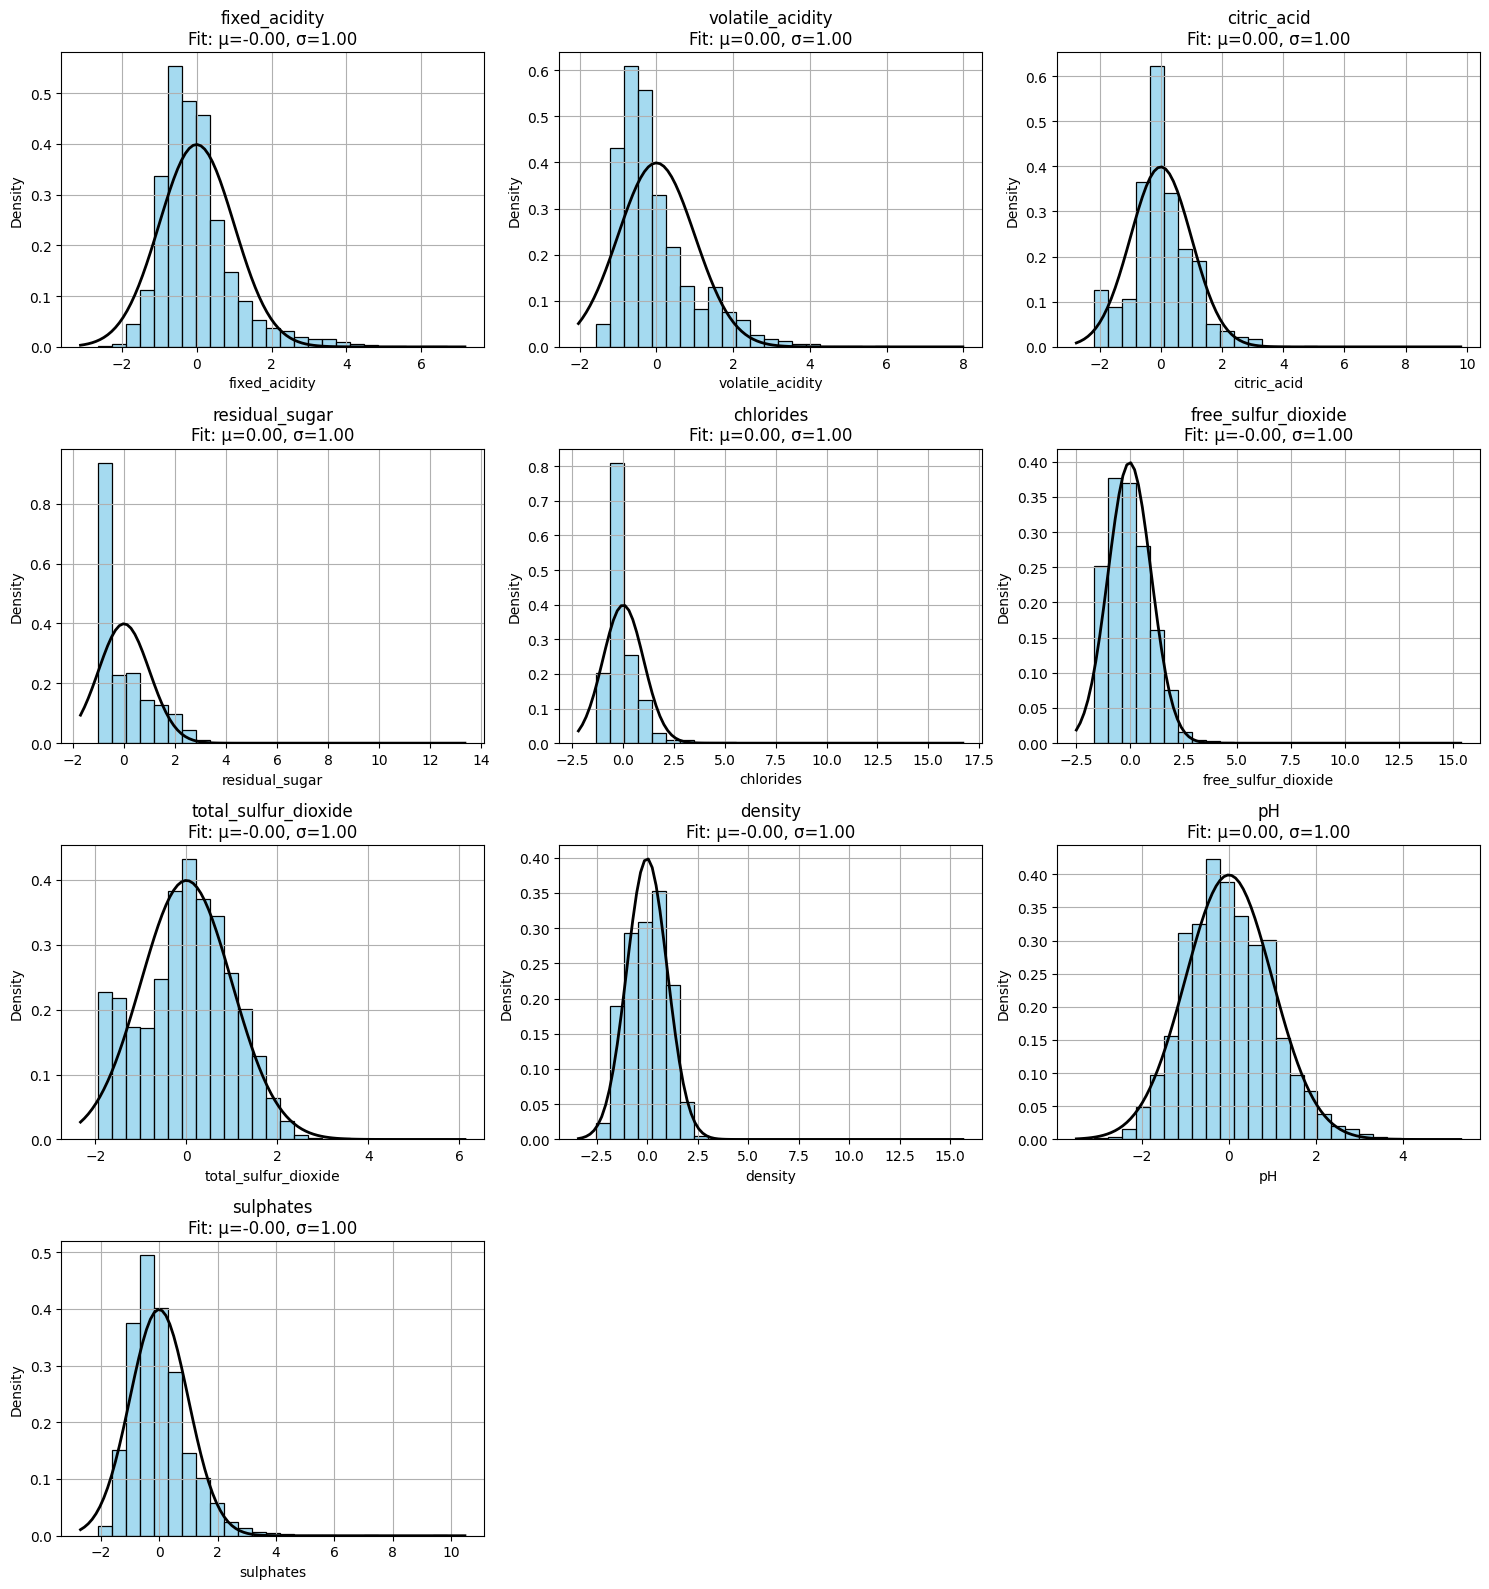

Testing normality for alcohol...


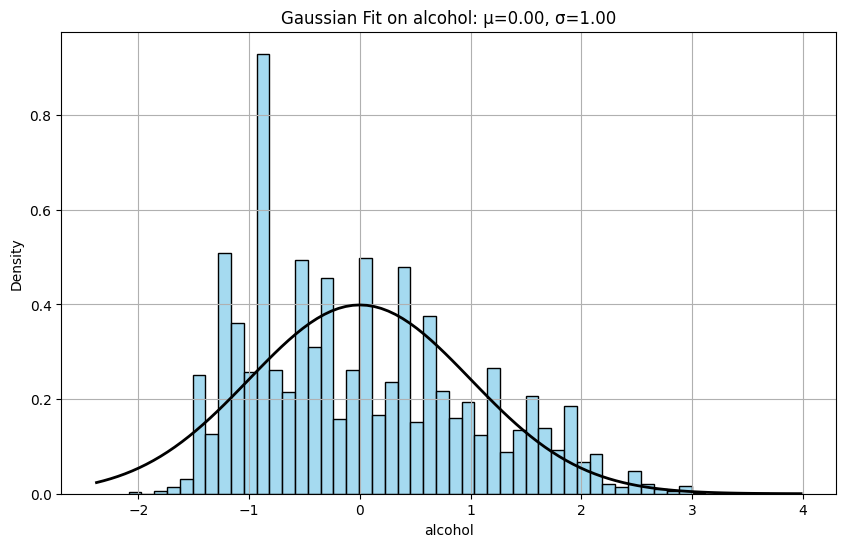

Computing PDF values...
Applying KMeans clustering...
Identifying anomalies...
Computing and plotting silhouette scores...


c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (112). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (113). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (114). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: ConvergenceWarning: Number of dist

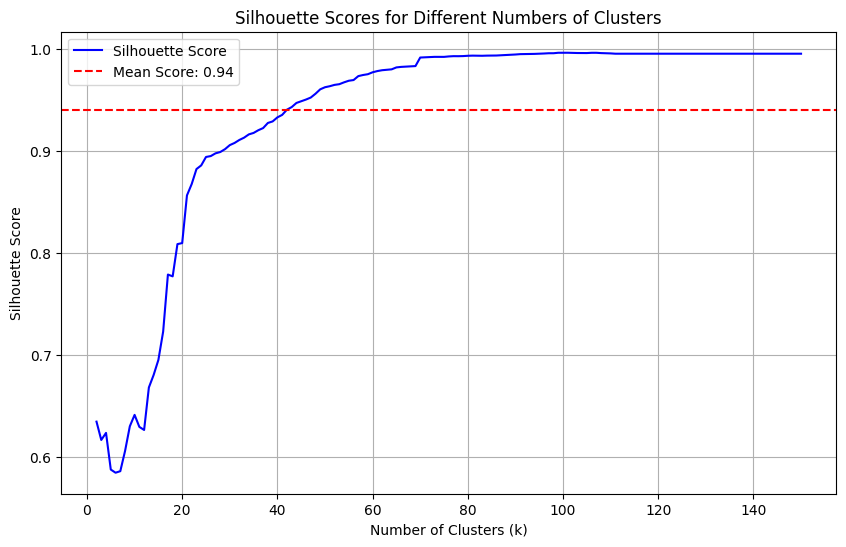

Visualizing results...


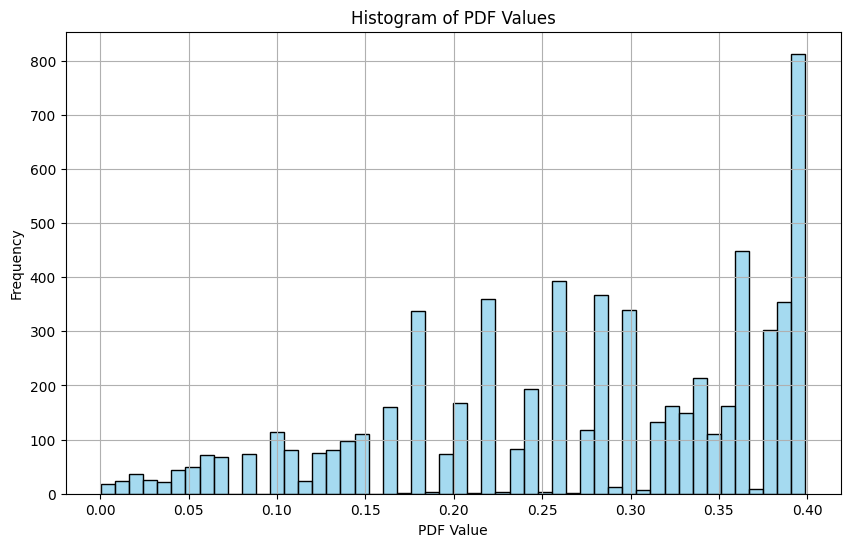

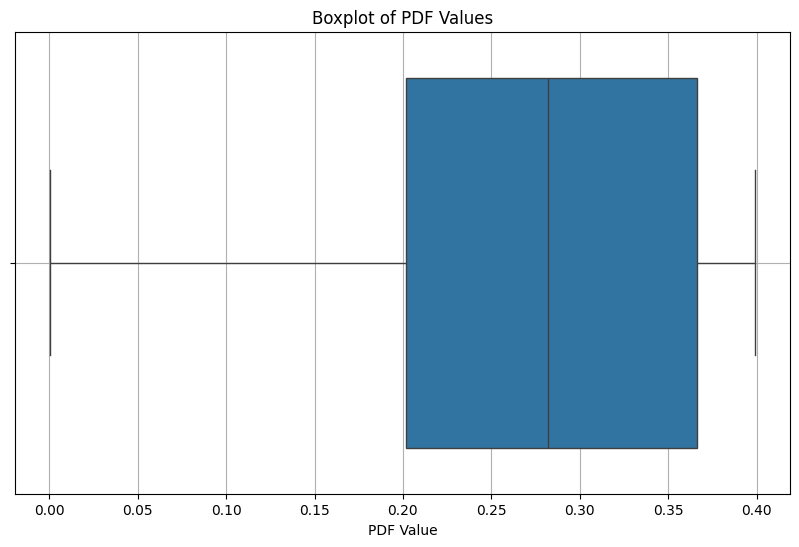

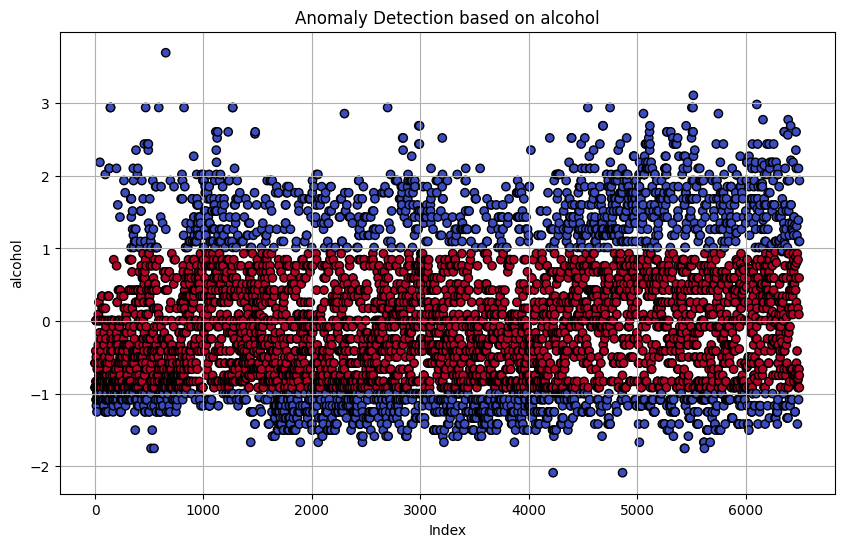

   alcohol  Anomaly
0      9.4    False
1      9.8    False
2      9.8    False
3      9.8    False
4      9.4    False


In [11]:
if __name__ == "__main__":
    result_df = run_anomaly_detection(feature_name='alcohol', wine_type='white')
    print(result_df[['alcohol', 'Anomaly']].head())